# Title-Image DistilFND model variant

`Title-Image DistilFND` extracts signficant textual and visual features from Reddit-post title and image in order to learn to classify Reddit-Posts from `Fakeddit`benchmark dataset by leveraging multi-modal feature extraction after *Nakamura et al. (2020)*. The `Image-Feature Extractor` leverages a pre-trained `ResNet34` model after *He et al. (2015)* trained on the `ImageNet 2012` benchmark dataset for image classification tasks. The `Title-Feature Extractor`leverages a pre-trained `DistilBert`model after *Sanh et al. (2020)* trained on the `English Wikipedia`and `Toronto Book Corpus` in lower cased letters. The model tries to reach a high generalzation capability by correctly classifing sample posts across *6* defined classes: authentic/true news content, Satire / Parody, content with false connection, imposter content, manipulated content and misleading content. Only the ladder *4* content types are to be understood as Fake News, whereas authentic/true content and Satire / Parody are to be understood as Authentic Content in terms of a *2*-way-classification task.

# Preparational steps

Checking information about attached GPU resource.

In [1]:
!nvidia-smi

Fri Sep  3 18:33:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importing needed modules

In [2]:
import os
import numpy as np
import keras
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from textwrap import wrap
from PIL import Image, ImageFile, UnidentifiedImageError
# Increasing maximum limit size for pixels per input image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000

In [4]:
# Importing Pytorch and transformers from HuggingFace
import torch
# Import nn module for building stacked layers and optimizers
from torch import nn, optim
import torchvision
from torchvision import datasets, models, transforms
# Import modules for dataset configuration and loading
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
# Importing model evaluation tools
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import sklearn
from sklearn.model_selection import train_test_split

In [7]:
# Importing visualization tools
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# Setting style of matplotlib graphic visualization
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Setting style of seaborn graphic visualization
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
COLOR_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLOR_PALETTE))

# Setting parameter figure sizes
rcParams["figure.figsize"] = 12, 8

Checking if GPU resource is accessible.

In [5]:
torch.cuda.is_available()

True

In [6]:
# Assigning available ressource to device variable, preferrably GPU resource
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print out if GPU or CPU is allocated
if str(device) == "cpu":
    print("CPU is allocated.")
else:
    print("GPU is allocated.")

GPU is allocated.


# Initializing and preparing Fakeddit-Benchmark dataset

Helper function to read in tsv files and return clean pandas dataframe.

In [8]:
# Method to read input data from tsv file into dataframe
def initialize_dataframe(path, file):
    dataframe = pd.read_csv(os.path.join(path, file), delimiter="\t")
    
    # Drop redundant column, if existent
    if "Unnamed: 0" in dataframe.columns:
        dataframe = dataframe.drop(["Unnamed: 0"], 1)
    
    # Return dataframe
    return dataframe

Read in tsv file and assign returned dataframes to training, validate and test splits.

In [9]:
# Read input into dataframes
df_test = initialize_dataframe("dataset", "multimodal_test_public.tsv")
df_validate = initialize_dataframe("dataset", "multimodal_validate.tsv")
df_train = initialize_dataframe("dataset", "multimodal_train.tsv")

Apply `train_test_split()` function from Scikit-learn in order to minimize complete dataset
with over *700.000* samples. Splitting complete dataset into custom training, validate and test sets,
while reusing only *20%* of the original data (*80%* for training and *10%* for validation and testing each). 
Stratify function is applied in order to keep the
per class sample distribution from original Fakeddit source dataset.

In [10]:
# Splitting complete Fakeddit-dataset into 20% training dataframe
# and 80% backup dataframe
df_train, df_backup = train_test_split(
    df_train,
    test_size=0.8,
    shuffle=True,
    # Apply stratification on basis of 6 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["6_way_label"]
)

In [11]:
# Keeping 80% of data samples for training and 20% for testing purposes
df_train, df_test = train_test_split(
    df_train,
    test_size=0.2,
    shuffle=True,
    # Apply stratification on basis of 6 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["6_way_label"]
)

In [12]:
# Dividing test split dataframe by factor 0,5 to have identically
# sized splits for validation and testing
df_test, df_validate = train_test_split(
    df_test,
    test_size=0.5,
    shuffle=True,
    # Apply stratification on basis of 6 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_test["6_way_label"]
)

In [13]:
# Checking size of training split dataframe
len(df_train)

90240

In [14]:
# Fake News subtypes in order of Fakeddit benchmark dataset labeling
CLASS_NAMES = ["True", "Satire", "False Conn.", "Impost. Content", "Man. Content", "Mis. Content"]

# Defining number of classes to be classified within classification problem
print("Fake News Classifier performs fine-grained fake news detection " + 
          "into a total of " + str(len(CLASS_NAMES)) + " classes.")

Fake News Classifier performs fine-grained fake news detection into a total of 6 classes.


In [15]:
# Importing needed modules for DistilBert model
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

# Loading DistilBert tokenizers adjusted for lower case English text corpus
# for tokenization of title input sequence
title_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Loading and processing input data

`PostDataset` class is subclass from PyTorch Dataset class. Following the `Dataset`& `DataLoader` PyTorch framework is implemented, in which PostDataset contains all relevant information per batch and DataLoader iterates over complete Dataset to feed batches of size *16* to model. **Attention:** `PostDataset` does not yet contain any information related to associated Reddit-Post images. Images per post are opened and processed *on thy fly* by using the post_id as search criteria.

In [16]:
class PostDataset(Dataset):
    
    # Constructor initialized with relevant attributes plus tokenizer information
    def __init__(self, post_id, title, label, title_tokenizer, max_len):
        self.post_id = post_id
        self.title = title
        self.label = label
        self.title_tokenizer = title_tokenizer
        self.max_length = max_len
        
    # Returns length of the dataset for internal looping 
    def __len__(self):
        return len(self.label)
    
    # Internal function to fetch next sample within dataset object
    def __getitem__(self, idx):
        # Iteration function to retireve next sample
        post_id = self.post_id[idx]
        title = self.title[idx]
        label = self.label[idx]

        # Saving id, clean_title and label entries per post
        # in sample dictionary
        sample = {
            "post_id": post_id,
            "clean_title": title,
            "label": label
        }
        
        # Return sample dictionary containing all needed attributes
        return sample

`train_transform()` function is specifically used to process image data for the `train_model()` function. Additional `data augmentation` is performed by random crop resizing and flipping image horizontally in order to artificially inflate the underlying training set split. Upsizing the training set by random modification of image data is a common regularization technique. Reddit-Post images are modified, converted to a `PyTorch` tensor representation and finally normalized. 

In [17]:
# Transform function for image processing (training)
# Performing data augmentation by random resizing, cropping
# and flipping images in order to artificially create new
# image data per training epoch
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

Internal `collate_batch()` function implements the processing / sample preparation logic to convert all information into a readable format for the neural network model. Per batch a total of *16* samples are fetched, whereas the images are processed and attributes post_id, image tensor, and *6*-way-label are stacked within a single batch dictionary. One batch holds above mentioned information for *16* fetched samples. `batch_size` of *16* was chosen in alignment with previously used `DistilBert` configuration. **Attention:** Because the input image data is differently processed depending on training or validation and test run, two separate `collate_batch` function are implemented. `collate_batch()` function is used by `PyTorch DataLoader` to process training data split, and `collate_batch_val_test()` function is used to process validation and test data split.

In [18]:
def collate_batch(batch):
    
    # List to save processed batch samples
    batch_processed = []
    
    # Iteration over input batch of size 16
    for i in range(len(batch)):
        
        # Saving attributes in local variables
        post_id = batch[i]["post_id"]
        title = batch[i]["clean_title"]
        label = batch[i]["label"]
        
        # Leveraging DistilBertTokenizer to generate
        # encoding of input text sequence
        encoding = title_tokenizer.encode_plus(
            title,
            max_length=80,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Try-Except-Else clause to process image data
        # Fetch images from image_set folder via post_id, transform and reshape tensor
        try:
            image = Image.open(f"/home/ubuntu/FakeNewsDetector/dataset/image_set/{post_id}.jpg")
        # Handling FileNotFoundError and randomly initializing pixels
        except FileNotFoundError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling UnidentifiedImageError and randomly initializing pixels
        except UnidentifiedImageError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling OSError and randomly initializing pixels
        except OSError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Else: Convert image to RGB, process with train_transform
        # and reshape to tensor of shape = [1, 3, 224, 224] for
        # [sample_count, color_channels, height in pixel, width in pixel]
        else:
            image = image.convert("RGB")
            image = train_transform(image)
            image = torch.unsqueeze(image, 0)
        

        # Storing processed attributes of sample in sample
        # dictionary: post_id, title (text), input_ids,
        # attention_mask, image and label
        sample = {
            "post_id": post_id,
            "title": title,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "image": image.flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }
        
        # Append current samples dictionary to processed
        # batch list --> List of sample dictionaries
        batch_processed.append(sample)
        
    # Complex operation in order to unpack list of dictionaries and
    # merge dictionary entries into correct PyTorch tensor for forward processing
    postId = []
    titles = []
    
    # For-loop to stack sample dictionary keys into appropriate format
    for i in range(len(batch_processed)):
        # If first sample of batch, initialize attribute tensors and reshape
        if i == 0:
            postId.append(batch_processed[i]["post_id"])
            titles.append(batch_processed[i]["title"])
            input_ids_tensor = batch_processed[i]["input_ids"].reshape(-1, 80)
            attention_mask_tensor = batch_processed[i]["attention_mask"].reshape(-1, 80)
            image_tensor = batch_processed[i]["image"].reshape(-1, 3, 224, 224)
            label_tensor = batch_processed[i]["label"].reshape(-1,)
            continue

        # Stack attributes of sample dictionary keys to generate correct tensor shape
        postId.append(batch_processed[i]["post_id"])
        titles.append(batch_processed[i]["title"])
        input_ids_tensor = torch.cat((input_ids_tensor, batch_processed[i]["input_ids"].reshape(-1, 80)))
        attention_mask_tensor = torch.cat((attention_mask_tensor, batch_processed[i]["attention_mask"].reshape(-1, 80)))
        image_tensor = torch.cat((image_tensor, batch_processed[i]["image"].reshape(-1, 3, 224, 224)))
        label_tensor = torch.cat((label_tensor, batch_processed[i]["label"].reshape(-1,)))
    
    # Returning batch list of sample dictionaries containing 16 processed samples
    return {
        "post_id": postId,
        "title": titles,
        "input_ids": input_ids_tensor,
        "attention_mask": attention_mask_tensor,
        "image": image_tensor,
        "label": label_tensor
    }

`create_data_loader` function initializes `Dataset` and `DataLoader` in connection with training dataset. `collate_batch()` function is given in `collate_fn` keyword. `batch_size` is set to 16 and `DataLoader` fetching operation is paralellized between 2 workers, e.g. threads.

- `params:`df (for Fakeddit source dataframe)
- `params:`tokenizer (for DistilBertTokenizer)
- `params:`max_len (of 80 tokens per input sequence)
- `params:`batch_size (of 16 samples per batch)
- `returns:`DataLoader object (iterable)

In [19]:
def create_data_loader(df, title_tokenizer, max_len, batch_size):
    
    # Initialization of PostDataset and assignment
    # to dataset variable
    dataset = PostDataset(
                post_id = df["id"].to_numpy(),
                title = df["clean_title"].to_numpy(),
                label = df["6_way_label"].to_numpy(),
                title_tokenizer = title_tokenizer,
                max_len = max_len
              )
    
    # Forwarding dataset variable, batch_size and collate_batch function
    # to PyTorch DataLoader module. Returns Iterable DataLoader object
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch, num_workers=2, pin_memory=True, prefetch_factor=2)

`val_test_transform()` function is specifically used to process image data for the `evaluate_model()` function. **NO** additional `data augmentation` is applied to image data, because for validation and testing artifical inflation for dataset splits is not needed. Hence, simple resizing and center cropping is performed, befoe converting images to a `PyTorch` tensor representation and finally normalizing them.

In [20]:
# Transform function for image processing (validation and testing)
# No data augmentation in validation and test data splits in order to
# define constant validation and testing process
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

Internal `collate_batch_val_test()` function implements the processing / sample preparation logic to convert all information into a readable format for the neural network model. Per batch a total of *16* samples are fetched, whereas the images are processed and attributes post_id, image tensor, and *6*-way-label are stacked within a single batch dictionary. One batch holds above mentioned information for *16* fetched samples. `batch_size` of *16* was chosen in alignment with previously used `DistilBert` configuration. **Attention:** Because the input image data is differently processed depending on training or validation and test run, two separate `collate_batch` function are implemented. `collate_batch()` function is used by `PyTorch DataLoader` to process training data split, and `colatte_batch_val_test()` function is used to process validation and test data split.

In [21]:
def collate_batch_val_test(batch):
    
    # List to save processed batch samples
    batch_processed = []
    
    # Iteration over input batch
    for i in range(len(batch)):
        
        # Iteration over input batch of size 16
        post_id = batch[i]["post_id"]
        title = batch[i]["clean_title"]
        label = batch[i]["label"]
        
        # Leveraging DistilBertTokenizer to generate
        # encoding of input text sequence
        encoding = title_tokenizer.encode_plus(
            title,
            max_length=80,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Try-Except-Else clause to process image data
        # Fetch images from image_set folder via post_id, transform and reshape tensor
        try:
            image = Image.open(f"/home/ubuntu/FakeNewsDetector/dataset/image_set/{post_id}.jpg")
        # Handling FileNotFoundError and randomly initializing pixels
        except FileNotFoundError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling UnidentifiedImageError and randomly initializing pixels
        except UnidentifiedImageError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling OSError and randomly initializing pixels
        except OSError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Else: Convert image to RGB, process with train_transform
        # and reshape to tensor of shape = [1, 3, 224, 224] for
        # [sample_count, color_channels, height in pixel, width in pixel]
        else:
            image = image.convert("RGB")
            image = train_transform(image)
            image = torch.unsqueeze(image, 0)
        

        # Storing processed attributes of sample in sample
        # dictionary: post_id, title (text), input_ids,
        # attention_mask, image and label
        sample = {
            "post_id": post_id,
            "title": title,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "image": image.flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }
        
        # Append current samples dictionary to processed
        # batch list --> List of sample dictionaries
        batch_processed.append(sample)
        
    # Complex operation in order to unpack list of dictionaries and
    # merge dictionary entries into correct PyTorch tensor for forward processing
    postId = []
    titles = []
    
    # For-loop to stack sample dictionary keys into appropriate format
    for i in range(len(batch_processed)):
        if i == 0:
            # If first sample of batch, initialize attribute tensors and reshape
            postId.append(batch_processed[i]["post_id"])
            titles.append(batch_processed[i]["title"])
            input_ids_tensor = batch_processed[i]["input_ids"].reshape(-1, 80)
            attention_mask_tensor = batch_processed[i]["attention_mask"].reshape(-1, 80)
            image_tensor = batch_processed[i]["image"].reshape(-1, 3, 224, 224)
            label_tensor = batch_processed[i]["label"].reshape(-1,)
            continue

        # Stack attributes of sample dictionary keys to generate correct tensor shape
        postId.append(batch_processed[i]["post_id"])
        titles.append(batch_processed[i]["title"])
        input_ids_tensor = torch.cat((input_ids_tensor, batch_processed[i]["input_ids"].reshape(-1, 80)))
        attention_mask_tensor = torch.cat((attention_mask_tensor, batch_processed[i]["attention_mask"].reshape(-1, 80)))
        image_tensor = torch.cat((image_tensor, batch_processed[i]["image"].reshape(-1, 3, 224, 224)))
        label_tensor = torch.cat((label_tensor, batch_processed[i]["label"].reshape(-1,)))
    
    # Returning batch list of sample dictionaries containing 16 processed samples
    return {
        "post_id": postId,
        "title": titles,
        "input_ids": input_ids_tensor,
        "attention_mask": attention_mask_tensor,
        "image": image_tensor,
        "label": label_tensor
    }

`val_test_create_data_loader` function initializes `Dataset` and `DataLoader` in connection with validation and test dataset. `collate_batch_val_test()` function is given in `collate_fn` keyword. `batch_size` is set to *16* and `DataLoader` fetching operation is parallelized between *2* workers, e.g. threads.

- `params:`df (for Fakeddit source dataframe)
- `params:`tokenizer (for DistilBertTokenizer)
- `params:`max_len (of 80 tokens per input sequence)
- `params:`batch_size (of 16 samples per batch)
- `returns:`DataLoader object (iterable)

In [22]:
def val_test_create_data_loader(df, title_tokenizer, max_len, batch_size):
    
    # Initialization of PostTitleDataset and assignment
    # to dataset variable
    dataset = PostDataset(
                post_id = df["id"].to_numpy(),
                title = df["clean_title"].to_numpy(),
                label = df["6_way_label"].to_numpy(),
                title_tokenizer = title_tokenizer,
                max_len = max_len
              )
    
    # Forwarding dataset variable, batch_size and collate function
    # to Pytorch DataLoader module. DataLoader is returned, over which
    # can be iterated
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch_val_test, num_workers=2, pin_memory=True, prefetch_factor=2)

Initializing PyTorch `DataLoader` objects for training, validation and test splits respectively inlcuding constants for maximum sequence length `MAX_LEN=80` and `BATCH_SIZE=16`. `next(iter())` function fetches first batch of **16 samples** from processed batch.

In [23]:
%%time
# Defining batch size and maximum sequence length
# MAX_LEN is defined based on plotting of token length dsitribution
BATCH_SIZE = 16
MAX_LEN = 80

# Initializing Pytorch DataLoader for train, validate and test split dataframes
train_data_loader = create_data_loader(df_train, title_tokenizer, MAX_LEN, BATCH_SIZE)
validate_data_loader = val_test_create_data_loader(df_validate, title_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = val_test_create_data_loader(df_test, title_tokenizer, MAX_LEN, BATCH_SIZE)

# Retrieving first batch from dataloaders via next() and iter() functions
train_data = next(iter(train_data_loader))
validate_data = next(iter(validate_data_loader))
test_data = next(iter(test_data_loader))

CPU times: user 1.94 s, sys: 1.14 s, total: 3.08 s
Wall time: 4.61 s


In [24]:
# Printing out PostIds and Post Title
print(test_data["post_id"])
print()
print(test_data["title"])
print()

# Printing Pytorch Tensor shapes
print(test_data["input_ids"].shape)
print(test_data["attention_mask"].shape)
print(test_data["image"].shape)
print(test_data["label"].shape)

['clf57rq', 'cdh98k5', 'dhd436', 'dbq6ao', 'cenr9qc', 'cqy6qb', 'besgfy', 'c3s4wr', 'cjpkaj7', '8lb66e', '78hxwb', '5qd6um', 'ddmp2m', '1mwwev', '8a1bdb', '6he8t3']

['she sees dead people', 'yeah i know im awesome', 'this blanket and how it looks close up', 'paper snowflakes cut into star wars shapes', 'other discussions', 'rochester airport security worker fired after passing mean note to traveler', 'the cleaning crews use a magnetic strip on the front of the vacuums in an office building', 'the way this c coin fits perfectly in my nail scissors', 'who can resist on the first snowfall of the year', 'us troops days before operation iceberg the invasion of okinawa late', 'lockheedmartin begins work on hardware design for nasas lunar orbiting deep space network could face telecommunications traffic jam on mars', 'elephant drinking out of a toilet', 'hitler gives speech at secret nazi hideout in antarctica colorised', 'happy baby with one tooth or screaming manta fish', 'ice agents feeli

In [25]:
# Printing out PostIds and Post Title
print(train_data["post_id"])
print()
print(train_data["title"])
print()

# Printing Pytorch Tensor shapes
print(train_data["input_ids"].shape)
print(train_data["attention_mask"].shape)
print(train_data["image"].shape)
print(train_data["label"].shape)

['bm9i6m', 'c5lexma', '8tely9', '2xd0ia', '3beg52', '6otbgh', '8ihmtn', 'as4j73', '9j4x1b', 'dt0tn9e', 'ckwf92c', 'czxq54', '6agmep', 'd3vqdpl', 'canovgz', '6si79v']

['honda civic refusing to start engine in solidarity with striking uber workers', 'im going to hell for this', 'marine just after digging a trench before the battle of stalingrad', 'sunshine after the us eastern snowstorms makes this guy super happy', 'someone took their happy pills today', 'arrr ye think ye can with the jackpot', 'sturm ruger will track gun violence after shareholders back activist resolution', 'sick fuck strips children', 'this spider that got stuck on fly tape', 'best star wars game ever made', 'obligatory', 'new alternatehistory drama examines what would have happened if nazis won nba finals', 'utah establishments must choose between bar and restaurant signs', 'longing to be serenaded', 'i did not have sex with that trophy', 'leaked picture of the face behind the dril twitter account']

torch.Size([16

In [26]:
# Printing out PostIds and Post Title
print(validate_data["post_id"])
print()
print(validate_data["title"])
print()

# Printing Pytorch Tensor shapes
print(validate_data["input_ids"].shape)
print(validate_data["attention_mask"].shape)
print(validate_data["image"].shape)
print(validate_data["label"].shape)

['v5ih3', 'ctqsk4r', '657w26', '1fxs36', '6fyeqv', 'cfjgjgs', 'br9eft', 'cm5zuvb', '9js9ef', 'cumkd4o', '8cibxu', 'cbeugfv', '6df6up', 'cfaw9oa', '3g5e63', 'biuzae']

['propagandaoriented oldsmobile ad featuring the snorting bull us life magazine', 'breaking news', 'danish airforce show their first mass produced fighter plane', 'good boy juicer good boy', 'maybe old and shabby but always happy to see me', 'dont drive drunk', 'brewed last year at vistas indian joe cheers for sarah raised for childhood cancer treatment', 'haka', 'jeff flake learns steve carell is leaving the office circa', 'agent poyo', 'ww soldier listening to orders', 'this is just terrifying', 'tiger mom gives birth yet nobody can believe what they find under her legs', 'other discussions', 'man caught having sex with his dog after accidentally phoning a friend during the act', 'this fuzzy little moth has been hanging around my porch in north texas']

torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16, 3, 224, 2

# Title-Image DistilFND model definition

`FakeNewsDetector` class processes post title and image data with `DistilBert` and `ResNet34` base model for `title_module`and `image_module` respectively, and is derived of `nn.Module` model super class from `torch.nn module`. `Image DistilFND` takes processed images per Reddit-Post and classifies Reddit-Posts into one of *6* defined classes via `Softmax` activation function.

In [66]:
class FakeNewsDetector(nn.Module):
    
    def __init__(self, num_classes):
        super(FakeNewsDetector, self).__init__()
        # Loading DistilBertModel with pre-trained model weights from English lower case text corpus
        # and assigning to title_module (Title-Feature Extractor)
        self.title_module = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        # Loading ResNet34 model with pre-trained model weights from ImageNet 2012 Benchmark dataset
        # and assigning to image_module (Image-Feature Extractor)
        self.image_module = models.resnet34(pretrained="imagenet")
        
        # Dropout layer to randomly nullify 30% of elements of output tensors --> Useful only in model training
        # Layer is still needed for loading model
        self.drop = nn.Dropout(p=0.3)

        # Fully connected layers (Linear layer) to reshape dimensionality of output tensors ([batch_size, num_classes])
        # Reshaping title feature tensor (768,) --> (1, 6)
        self.fc_title = nn.Linear(in_features=self.title_module.config.hidden_size, out_features=num_classes, bias=True)
        # Reshaping image feature tensor (1, 1000) --> (1, 6)
        self.fc_image = nn.Linear(in_features=1000, out_features=num_classes, bias=True)

        # Final model prediction via Softmax activation function
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, title_input_ids, title_attention_mask, image):
        # Applying title_module onto post_title input_ids and attention_mask
        # Returning title feature tensor of shape (768,)
        title_last_hidden_states = self.title_module(
            input_ids = title_input_ids,
            attention_mask = title_attention_mask,
            return_dict=False
        )
        # List Slicing operation applied to output of last hidden layer of DistilBert model in order to
        # only return tensor representation of aggregated classification output ([CLS] token)
        # and assign to pooled output variable
        title_pooled_output = title_last_hidden_states[0][:, 0, :]
        # Random element nullification of pooled output tensor
        # Layer is still needed for loading model
        title_pooled_output = self.drop(title_pooled_output)
        
        # Condense model outputs via fully connected layer to match hidden units of 224
        # Output is tensor of shape (16, 6)
        title_output = self.fc_title(title_pooled_output)
        # image_condensed = self.fc_image(image_output)

        # Output from ResNet34 in shape = (16, 1000) for 1000 classes in correspondence ot ImageNet dataset
        image_output = self.image_module(image)
        # Random element nullification of image output tensor
        # Layer is still needed for loading model
        image_output = self.drop(image_output)
        
        # Linear layers per title, image and comment tensor output to convert into aligned dimensionality
        # Takes as input the respected title, image and comment tensors and reshapes to shape = (1, 6)
        # for [one sample, 6 defined classes]
        image_output = self.fc_image(image_output)

        # Fusion of textual and visual feature tensors to multi-modal feature tensor
        # of shape (16, 6) by leveraging element-wise maximum method
        fusion = torch.maximum(title_output, image_output)
        
        # Applying Softmax activation function on complete feature vector
        # to return class-specific probability distribution
        return self.softmax(fusion)

# Initializing Title-Image DistilFND and asigning to fn_detector variable
fn_detector = FakeNewsDetector(len(CLASS_NAMES))
# Moving model to device resource
fn_detector = fn_detector.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
# Printing model architecture
print(fn_detector)

FakeNewsDetector(
  (title_module): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

# Model training setup / configuration

Hyperparameter configuration in preparation for training procedure on `Fakeddit`benchmark dataset.
- `LearningRate Scheduler (LRScheduler)`: Reduces learning rate by factor `LR_FACTOR` with patience `LR_PATIENCE` if validation error `val_loss` rises for two consecutive epochs until minimum learning rate of `MIN_LR` is reached.
- `Early Stopping` mechanism: Aborts training with patience `ES_PATIENCE` if subtraction of validate error `val_loss` of epoch *i* and validate error `val_loss` of epoch *i + 1* is below `MIN_DELTA`.

In [30]:
# Setting LR Scheduler hyperparameters
LR_FACTOR=0.5
MIN_LR=1e-6
LR_PATIENCE=1

# Setting Early Stopping hyperparameters
ES_PATIENCE = 4
MIN_DELTA = 0

Class `LRScheduler()` implements learning rate scheduler with `ReduceLROnPlateau` optimization, meaning that learning rate is reduced if plateau is reached (rising validation error `val_loss` for two consecutive epochs).

In [31]:
class LRScheduler():
    
    # Constructor for LRScheduler class
    def __init__(self, optimizer, patience=LR_PATIENCE, min_lr=MIN_LR, factor=LR_FACTOR):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode = "min",
            patience = self.patience,
            factor = self.factor,
            min_lr = self.min_lr,
            verbose = True
        )
        
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

Class `EarlyStopping` implements early stopping mechanism with constants `ES_PATIENCE` and `MIN_DELTA`.

In [32]:
class EarlyStopping():
    
    # Constructor for EarlyStopping class
    def __init__(self, patience=ES_PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    # Call function implements comparison of validation error val_loss of epoch i with val_loss
    # of epoch i + 1 --> Counter until max. 4 epochs initialized
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss <= self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}.")
            if self.counter >= self.patience:
                print("INFO: Early Stopping!")
                self.early_stop = True

`get_class_weights()` function calculates percentage values per class for a weighted `CrossEntropy`. Reasoning is an highly imbalanced Fakeddit benchmarks dataset. Classes with a high number of Reddit-Post samples are normalized and are considered less by percentage during loss calculation. Also, some classes have considerably more sample data, all classes are weighted and taken as input into the loss calculation according to their respective number of samples. High number of class samples yields lower percentage weights, and low number of class samples yields higher percentage weight.
- `params`: dataframe (Fakeddit training split dataframe - sample distribution in all splits identical)
- `returns`: class_weights (percentage points per class in intervall between *0* and *1*

In [44]:
def get_class_weights(dataframe):
    
    # Count labels per class / subtype of Fake News in training set split
    # in sorted order 0, 1, 2, 3, 4, 5 and put into label_count list
    label_count = [dataframe["6_way_label"].value_counts().sort_index(0)[0],
                   dataframe["6_way_label"].value_counts().sort_index(0)[1],
                   dataframe["6_way_label"].value_counts().sort_index(0)[2],
                   dataframe["6_way_label"].value_counts().sort_index(0)[3],
                   dataframe["6_way_label"].value_counts().sort_index(0)[4],
                   dataframe["6_way_label"].value_counts().sort_index(0)[5]]

    # Calculate weights per class by subtracting from 1 label_count per class divided
    # by sum of all label_counts
    class_weights = [1 - (x / sum(label_count)) for x in label_count]
    # Converting list of class_weights to float PyTorch tensor and assigning to device
    class_weights = torch.FloatTensor(class_weights)

    # Returns class_weights tensor of data type float
    return class_weights

In [36]:
# Calculate class weights on basis of training split dataframe and print weight tensor
class_weights = get_class_weights(df_train)
print(class_weights)

tensor([0.6062, 0.9406, 0.8099, 0.9791, 0.7024, 0.9617])


`Hyperparameters` for training Title-Image DistilFND are set in the following section.

In [70]:
# Training for a total of 20 epochs
EPOCHS = 20

# Initializing AdamW optimizer for trainable parameters with initial learning rate of 3e-5
optimizer = AdamW(fn_detector.parameters(), lr=3e-5, correct_bias=False)

# Definiing toal training steps by multiplying length of samples per DataLoader by EPOCHS
total_steps = len(train_data_loader) * EPOCHS

# Initializing linear scheduling warmup for training procedure
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Initializing weighted Cross Entropy Loss function and assignment to device
loss_function = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Initializing Learning Rate Scheduler with AdamW optimizer and Early Stopping mechanism
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()

# Model training procedure

`train_model()` function is called to train fake news detector on basis of `Fakeddit` training set split.
- `params`: model (Title-Image DistilFND)
- `params`: data_loader (PyTorch sample DataLoader)
- `params`: loss_function (weighted Cross Entropy Loss)
- `params`: optimizer (AdamW)
- `params`: device (either GPU or CPU resource)
- `params`: scheduler (configuration of warmup procedure)
- `params`: num_examples (count of batches of respective data split containing a total of 16 samples)
- `returns`: training accuracy `train_acc` per epoch (`correct_preds.double() / num_examples`)
- `returns`: mean of training loss value `train_loss

In [71]:
def train_model(model, data_loader, loss_function, optimizer, device, scheduler, num_examples):
    print("Training model in progress...")
    print("-" * 10)
    
    # Putting model in training condition including regularization layers
    model = model.train()
    
    # Saving training lossses per epoch and initalizing correct prediction count
    train_losses = []
    correct_preds = 0
    
    # Iteration over data (batches) contained in data split set DataLoader
    for data in tqdm(data_loader):

        # Initializing post title input_ids, attention_mask, 
        # image data and label per Reddit-Post and assigning to device
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        images = data["image"].to(device)
        labels = data["label"].to(device)

        # Feeding input data to Title-Image DistilFND
        outputs = model(
                title_input_ids = input_ids,
                title_attention_mask = attention_mask,
                image = images
        )

        # Final Softmax layer returns class predictions per sample in batch
        # Highest probability value resembles class prediction and is assigned to preds variable
        _, preds = torch.max(outputs, dim=1)

        # Training loss is calculated by applying weighted Cross Entropy Loss
        # on comparison between predicted label and ground truth label
        train_loss = loss_function(outputs, labels)

        # Counting correct model predictions and incrementing correct prediction count
        correct_preds += torch.sum(preds == labels)
        # Append training loss of current epoch to list of training losses
        train_losses.append(train_loss.item())
        # Initialize backpropagation to adjust model weights / parameters
        train_loss.backward()
        # Normalize gradient values to regularize parameter update
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Perform parameter update based on current gradient value
        optimizer.step()
        # Moving scheduler to next step / iteration
        scheduler.step()
        # Zero out current gradients to initialize fresh optimizer state for next epoch
        optimizer.zero_grad()
            
    # Return train_acc and train_loss values
    return correct_preds.double() / num_examples, np.mean(train_losses)

`evaluate_model()` function is used to evaluate the current state of the fake news detector in each epoch after completed iteration over training set split. Evaluation is performed on validation data split. In evaluation mode no model parameter updates are condusted. Hence, there is no need for an optimizer, but validation accuracy `val_acc` and validation loss `val_loss` is calculated.
- `params`: model (Title-Image DistilFND)
- `params`: data_loader (PyTorch sample DataLoader)
- `params`: loss_function (weighted Cross Entropy Loss)
- `params`: device (either GPU or CPU resource)
- `params`: num_examples (count of batches of respective data split containing a total of 16 samples)
- `returns`: validation accuracy `val_acc`per epoch (`correct_preds.double() / num_examples`)
- `returns`: mean of validation loss value `val_loss

In [72]:
def evaluate_model(model, data_loader, loss_function, device, num_examples):
    print("Validating model in progress...")
    print("-" * 10)
    
    # Switching off regularization and normalization layers for evaluation mode
    # Hence, no model parameters are adjusted. Model is evaluated in current state
    model = model.eval()
    
    # Saving validation loss per epoch
    val_losses = []
    correct_preds = 0
    
    # Skipping gradient calulation over weights --> Not needed, because
    # no parameters are updated and significantly speeds up iteration over samples batches
    with torch.no_grad():
        # Iteration over data (batches) contained in data split set DataLoader
        for data in tqdm(data_loader):
            
            # Initializing post title input_ids, attention_mask, 
            # image data and label per Reddit-Post and assigning to device
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            images = data["image"].to(device)
            labels = data["label"].to(device)
            
            # Feeding input data to Title-Image DistilFND state in current epoch
            outputs = model(
                    title_input_ids = input_ids,
                    title_attention_mask = attention_mask,
                    image = images
            )
            
            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)
            
            # Validation loss is calculated by applying weighted Cross Entropy Loss
            # on comparison between predicted label and ground truth label
            val_loss = loss_function(outputs, labels)
            
            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == labels)
            
            # Appending current validation loss per batch
            # to list of validation losses per epoch
            val_losses.append(val_loss.item())
    
    # Returns val_acc and val_loss values
    return correct_preds.double() / num_examples, np.mean(val_losses)

`Training loop` integrates `Hyperparameters`, `train_model()` and `evaluate_model` function into one training loop. Title DistilFND iterates over training and validation data splits a total of *20* times for the total number of epochs. Training history, `train_acc`, `train_loss`, `val_acc` and `val_loss` per epoch are saved in `history` dictionary for analysis after training procedure is completed. After each epoch the current state of model and optimizer is saved in a checkpoint and if the `val_acc` has increased in comparison to previous epoch, the complete model is saved as a `pth` file with the `torch.save` function.

#### First training run (10/20 epochs)

In [74]:
%%time

# Initializing training history dictionary and best_accuracy variable
history = defaultdict(list)
best_accuracy = 0

# Iteration times the total number of epochs
for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Calling train_model() function, returns train_acc and train_loss
    train_acc, train_loss = train_model(
        fn_detector,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    # Print train_loss and train_acc values for current epoch
    print(f"Train loss {train_loss} | Accuracy {train_acc}")
    print()

    # Calling evaluate_model() function, returns val_acc and val_loss
    val_acc, val_loss = evaluate_model(
            fn_detector,
            validate_data_loader,
            loss_function,
            device,
            len(df_validate)
    )

    # Print val_loss and val_acc values for current epoch
    print(f"Val   loss {val_loss} | Accuracy {val_acc}")
    print()

    # Save current values of train_acc, val_acc, train_loss and val_loss
    # in respective keys of history dictionary for later analysis
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    # Feed current val_loss to LRScheduler and Early Stopping
    # for evaluation
    lr_scheduler(val_loss)
    early_stopping(val_loss)
    # If val_loss increases in 4 consecutive epochs, abort training procedure
    if early_stopping.early_stop:
        break

    # Saving model checkpoint as dictionary and .tar file for continuing inference
    # Saving keys for current epoch, model state, optimizer state, val_acc and val_loss
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": fn_detector.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_acc": val_acc,
        "val_loss": val_loss
    }, f"/home/ubuntu/FakeNewsDetector/models/titleimage_research/checkpoints/title_detector_checkpoint_epoch_{epoch+1}.tar")

    # If val_acc has increased compared to previous epoch, complete model .pth file is saved
    if val_acc > best_accuracy:
        torch.save(fn_detector.state_dict(), f"/home/ubuntu/FakeNewsDetector/models/titleimage_research/best_title_detector_epoch_{epoch+1}.pth")
        best_accuracy = val_acc

# Print output when training procedure completed
print()
print("Completed Training!")
print("-" * 20)

Epoch 1/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.3337293170656719 | Accuracy 0.7414561170212767

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.3181675628567417 | Accuracy 0.7526595744680852

Epoch 2/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.3023550107335369 | Accuracy 0.7696254432624114

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2934460203698341 | Accuracy 0.7689716312056738

Epoch 3/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.2605181405941646 | Accuracy 0.8045766843971631

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2748456753737538 | Accuracy 0.7895390070921986

Epoch 4/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.2349336542981737 | Accuracy 0.8269281914893618

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2661732979700075 | Accuracy 0.7963652482269504

Epoch 5/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.2123285020285464 | Accuracy 0.8478834219858157

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2571902873668266 | Accuracy 0.799822695035461

Epoch 6/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1956322355684659 | Accuracy 0.863175975177305

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2558078584941565 | Accuracy 0.8016843971631207

Epoch 7/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.182338641869261 | Accuracy 0.8750110815602837

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2500093955520197 | Accuracy 0.8078014184397163

Epoch 8/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1715165302263084 | Accuracy 0.8850953014184397

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2472829350342987 | Accuracy 0.809131205673759

Epoch 9/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1642514289270902 | Accuracy 0.8922983156028369

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2421747681096935 | Accuracy 0.8167553191489362

Epoch 10/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.160758143177269 | Accuracy 0.8958444148936171

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.244939819633538 | Accuracy 0.8134751773049645

INFO: Early stopping counter 1 of 4.

Completed Training!
--------------------
CPU times: user 6h 15min 5s, sys: 1h 27min 56s, total: 7h 43min 1s
Wall time: 7h 37min 49s


**Attention:** Training was interrupted after *10* epochs in order to also evaluate model after *10*/*20* epochs. Afterwards, checkpoint of model and optimizer state was loaded to continue training on identical dataset splits. After a total of *15*/*20* epochs the model performance was saturated and was prematurely aborted by the `Early Stopping` mechanism.

#### Loading model and optimizer state to continue training

In [ ]:
# Initialize Title-Image DistilFND class and assign to fn_detector variable
fn_detector = FakeNewsDetector(len(CLASS_NAMES))
# Initiliaze optimizer AdamW
optimizer = AdamW(fn_detector.parameters(), lr=1e-5, correct_bias=False)

# Load model checpoint after 10 epochs of first training run
checkpoint = torch.load("/home/ubuntu/FakeNewsDetector/models/titleimage_research/checkpoints/title_detector_checkpoint_epoch_{epoch+1}.tar")

# Load model and optimizer state to continue training
fn_detector.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# Load epoch, val_loss and val_acc values for epoch 10 of first training run
epoch = checkpoint["epoch"]
val_loss = checkpoint["val_loss"]
val_acc = checkpoint["val_acc"]

# Assign loaded Title-Image DistilFND to resource
fn_detector.to(device)

#### Second training run (15/20 epochs)

In [89]:
%%time

# Initializing training history dictionary and best_accuracy variable
# No new history dictionary is initialized to append values to dicitionary from first run
# history = defaultdict(list)
best_accuracy = 0

# Iteration times the total number of epochs
for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 11}/{EPOCHS}")
    print("-" * 10)

    # Calling train_model() function, returns train_acc and train_loss
    train_acc, train_loss = train_model(
        fn_detector,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    # Print train_loss and train_acc values for current epoch
    print(f"Train loss {train_loss} | Accuracy {train_acc}")
    print()

    # Calling evaluate_model() function, returns val_acc and val_loss
    val_acc, val_loss = evaluate_model(
            fn_detector,
            validate_data_loader,
            loss_function,
            device,
            len(df_validate)
    )

    # Print val_loss and val_acc values for current epoch
    print(f"Val   loss {val_loss} | Accuracy {val_acc}")
    print()

    # Save current values of train_acc, val_acc, train_loss and val_loss
    # in respective keys of history dictionary for later analysis
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    # Feed current val_loss to LRScheduler and Early Stopping
    # for evaluation
    lr_scheduler(val_loss)
    early_stopping(val_loss)
    # If val_loss increases in 4 consecutive epochs, abort training procedure
    if early_stopping.early_stop:
        break

    # Saving model checkpoint as dictionary and .tar file for continuing inference
    # Saving keys for current epoch, model state, optimizer state, val_acc and val_loss
    torch.save({
        "epoch": epoch+11,
        "model_state_dict": fn_detector.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_acc": val_acc,
        "val_loss": val_loss
    }, f"/home/ubuntu/FakeNewsDetector/models/titleimage_research/checkpoints/title_detector_checkpoint_epoch_{epoch+11}.tar")

    # If val_acc has increased compared to previous epoch, complete model .pth file is saved
    if val_acc > best_accuracy:
        torch.save(fn_detector.state_dict(), f"/home/ubuntu/FakeNewsDetector/models/titleimage_research/best_title_detector_epoch_{epoch+11}.pth")
        best_accuracy = val_acc

# Print output when training procedure completed
print()
print("Completed Training!")
print("-" * 20)

Epoch 11/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1614307280761975 | Accuracy 0.8943705673758866

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.241796020920395 | Accuracy 0.8165780141843972

Epoch 12/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1615989386401278 | Accuracy 0.8945478723404255

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2449724488224543 | Accuracy 0.8137411347517731

INFO: Early stopping counter 1 of 4.
Epoch 13/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.160750805084587 | Accuracy 0.8954454787234043

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2435817661014854 | Accuracy 0.8145390070921986

INFO: Early stopping counter 2 of 4.
Epoch 14/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1613913071705095 | Accuracy 0.8946143617021277

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.2434110810570682 | Accuracy 0.8153368794326241

INFO: Early stopping counter 3 of 4.
Epoch 15/10
----------
Training model in progress...
----------


  0%|          | 0/5640 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 1.1613450073815406 | Accuracy 0.8947916666666668

Validating model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

Val   loss 1.243348542172858 | Accuracy 0.8154255319148936

INFO: Early stopping counter 4 of 4.
INFO: Early Stopping!

Completed Training!
--------------------
CPU times: user 3h 7min 20s, sys: 43min 47s, total: 3h 51min 8s
Wall time: 3h 48min 22s


Plotting and visualizing training history - `train_acc` vs. `val_acc` curves across *15*/*20* epochs. Accuracy values need to increase over time. Validation accuracy is a first indicator for model's capability to generalize, but needs confirmation on unseen data, e.g. test data split.

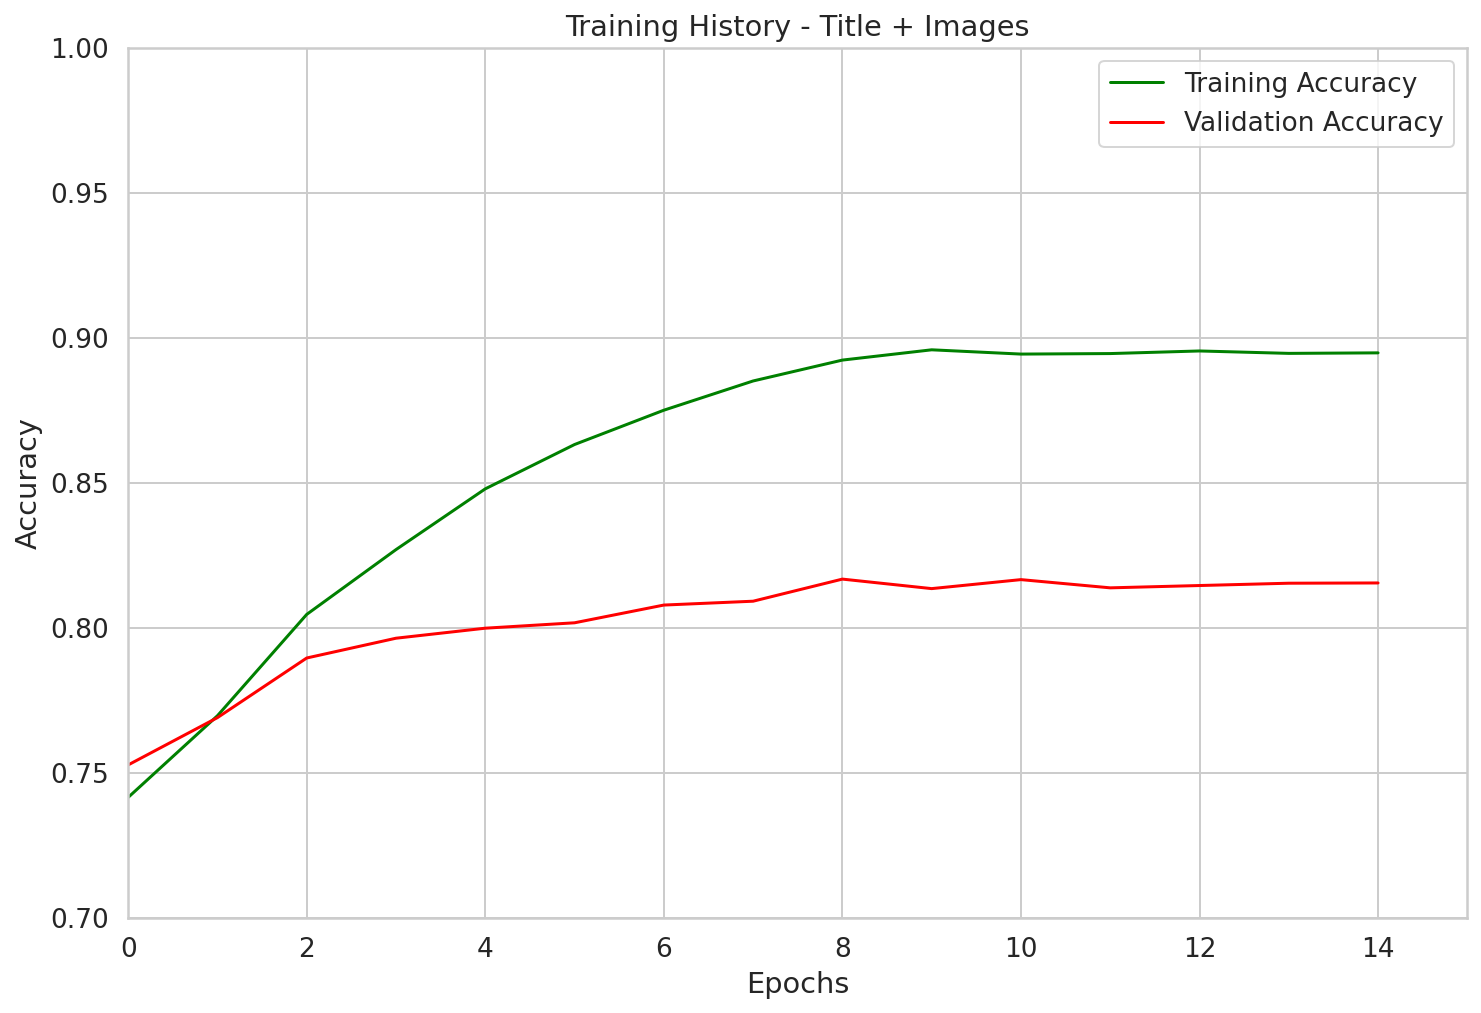

In [90]:
# Initializing accuracy plot name
acc_plot_name = "titleimage_detector_accuracy_training_results_15epochs"

# Plotting Training History per epoch (Accuracy) for Title-Image DistilFND
CLASSIFIER_STYLE = "Title + Images"

# Plotting training and validation accuracy curves across 20 epochs
plt.plot(history["train_acc"], color="green", label="Training Accuracy")
plt.plot(history["val_acc"], color="red", label="Validation Accuracy")

plt.title("Training History - {classifier}".format(classifier=CLASSIFIER_STYLE))
# Defining x- and y-axis labels
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
# Setting x- and y-axis scale
plt.ylim([0.7, 1])
plt.xlim([0, 15])
plt.legend()
# Saving plotted graph as jpg file
plt.savefig(f"/home/ubuntu/FakeNewsDetector/models/titleimage_research/{acc_plot_name}.jpg")
plt.show()

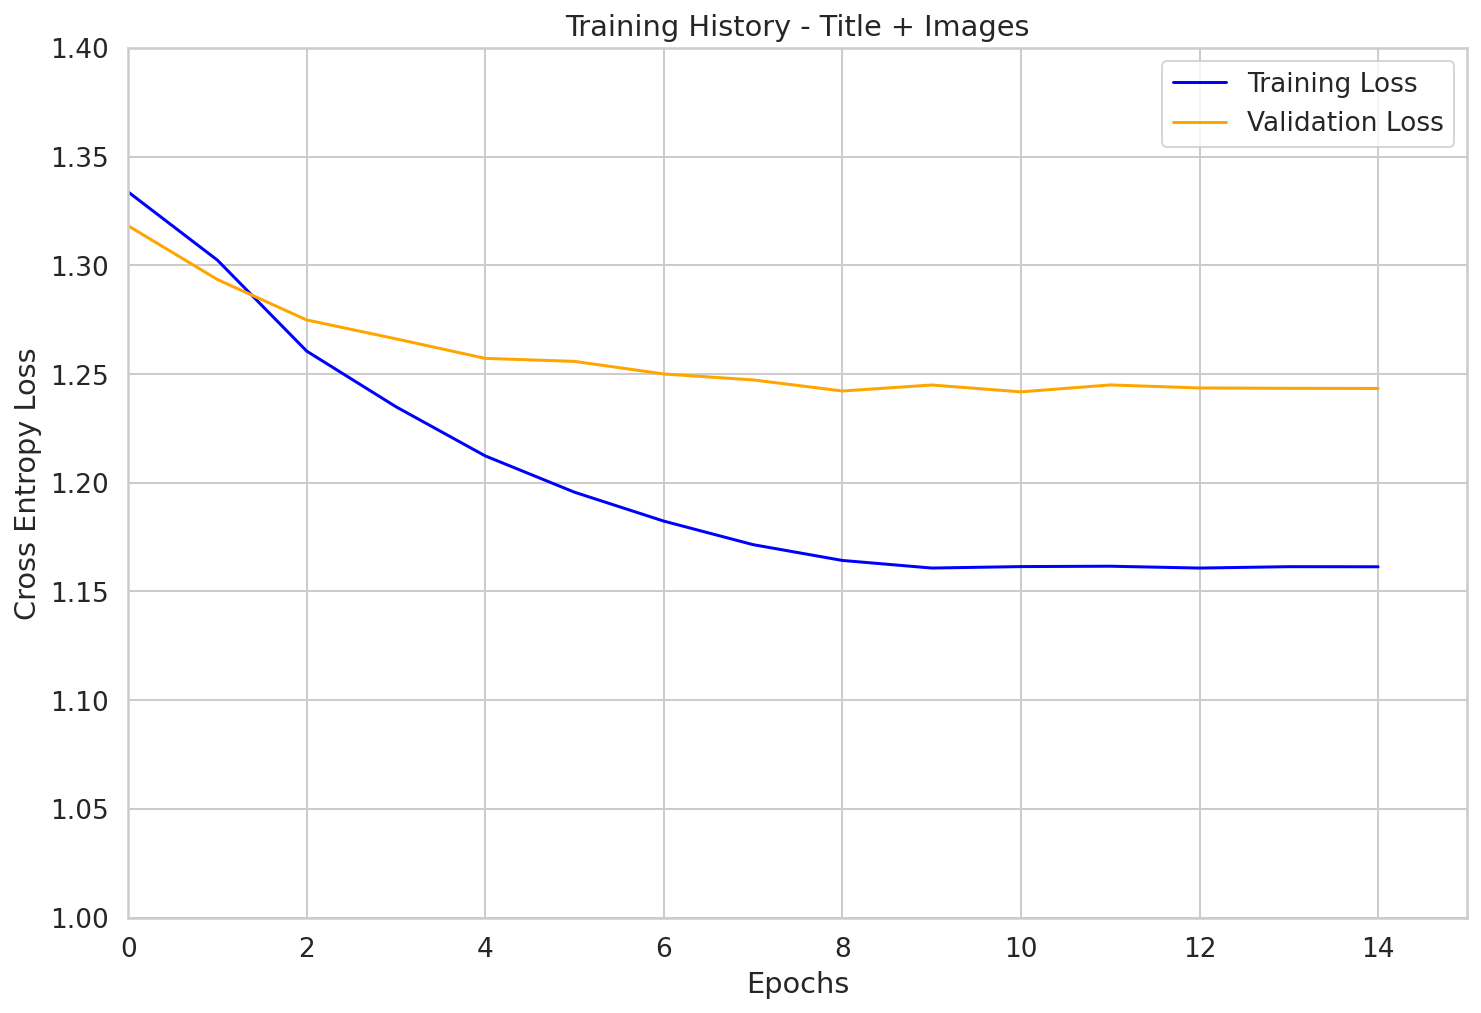

In [102]:
# Initializing loss plot name
loss_plot_name = "titleimage_detector_loss_training_results_15epochs"

# Plotting Training History per epoch (Loss) for Title-Image DistilFND
CLASSIFIER_STYLE = "Title + Images"

plt.plot(history["train_loss"], color="blue", label="Training Loss")
plt.plot(history["val_loss"], color="orange", label="Validation Loss")

plt.title("Training History - {classifier}".format(classifier=CLASSIFIER_STYLE))
# Defining x- and y-axis labels
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epochs")
# Setting x- and y-axis scale
plt.ylim([1, 1.4])
plt.xlim([0, 15])
plt.legend()
# Saving plotted graph as jpg file
plt.savefig(f"/home/ubuntu/FakeNewsDetector/results/titleimage_research/{loss_plot_name}.jpg")
plt.show()

# Testing Title-Image DistilFND model

`test_model()` function is used to evaluate model performance on previously unseen and unknown data. Hence, the training error is an indication for the model's capability to generalize well. For comparison of DistilFND model variants within the ablation study, the `test_acc` and `test_loss` values are used. Testing procedure is conducted for one iteration on test data split with identical size to validation data split.
- `params`: model (Title-Image DistilFND)
- `params`: data_loader (PyTorch sample DataLoader)
- `params`: loss_function (weighted Cross Entropy Loss)
- `params`: device (either GPU or CPU resource)
- `params`: num_examples (count of batches of respective data split containing a total of 16 samples)
- `returns`: test accuracy `test_acc` (`correct_preds.double() / num_examples`)
- `returns`: mean of test loss value `val_loss`
- `returns`: actual `post_titles` input sequences
- `returns`: model `predictions` per sample in batch
- `returns`: prediction distribution `prediction_probs` across classes per sample per batch
- `returns`: ground truth labels `real_labels` per sample in batch

In [92]:
def test_model(model, data_loader, loss_function, device, num_examples):
    print("Testing model in progress...")
    print("-" * 10)
    
    # Switching off regularization and normalization layers for evaluation mode
    # Hence, no model parameters are adjusted. Model is evaluated in current state
    model.eval()

    # Initializing list of test_losses and correct_preds
    test_losses = []
    correct_preds = 0
    
    # Initializing lists for post_titles, predictions,
    # prediction_probs and real_labels
    post_titles = []
    predictions = []
    prediction_probs = []
    real_labels = []
    
    # Skipping gradient calulation over weights --> Not needed, because
    # no parameters are updated and significantly speeds up iteration over samples batches
    with torch.no_grad():
        # Iteration over data (batches) contained in data split set DataLoader
        for data in tqdm(data_loader):
            
            # Initializing post title, input_ids, attention_mask,
            # image and label per Reddit-Post and assigning to device
            titles = data["title"]
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            images = data["image"].to(device)
            labels = data["label"].to(device)
            
            # Feeding input data to trained Title-Image DistilFND
            outputs = model(
                title_input_ids = input_ids,
                title_attention_mask = attention_mask,
                image = images
            )
            
            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)

            # Test loss is calculated by applying weighted Cross Entropy Loss
            # on comparison between predicted label and ground truth label
            test_loss = loss_function(outputs, labels)

            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == labels)

            # Appending current test loss per batch
            # to list of test losses
            test_losses.append(test_loss.item())
            
            # Append calulated values for sample to list of values per sample
            post_titles.extend(titles)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_labels.extend(labels)
    
    # Stack and concatenate calulated test values per batch
    test_acc = correct_preds.double() / num_examples
    test_loss = np.mean(test_losses)
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    real_labels = torch.stack(real_labels)
    
    # Return test_acc, test_loss, post_titles, predictions, prediction_probs, real_labels
    return test_acc, test_loss, post_titles, predictions, prediction_probs, real_labels

Calling `test_model()` function to test model's generalization capability after training procedure is concluded. Respective return values are saved in test_acc, test_loss is ignored, post_titles, y_preds, y_prediction_probs and y_test for gound truth labels.

In [93]:
# Testing model on test data split and initilaizing test values
test_acc, _, post_titles, y_preds, y_prediction_probs, y_test = test_model(
    fn_detector,
    test_data_loader,
    loss_function,
    device,
    len(df_test)
)

# Printing model test accuracy
print(f"Model testing accuracy for classifier: {CLASSIFIER_STYLE} = {test_acc}%")

Testing model in progress...
----------


  0%|          | 0/705 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Model testing accuracy for classifier: Title + Images = 0.8191489361702128%


Sckit-learn `Classification Report` returns defined average weighted evaluation metrics `precision`, `recall` and `f1-score` across all classes as well as class specific evaluation metrics. Those metrics are used to analyse models classification capability across all classes and class-specific.

In [94]:
# Plotting classification report
print(classification_report(y_test.cpu(), y_preds.cpu(), target_names=CLASS_NAMES))

                 precision    recall  f1-score   support

           True       0.81      0.87      0.84      4442
         Satire       0.67      0.53      0.59       670
    False Conn.       0.75      0.73      0.74      2144
Impost. Content       0.49      0.26      0.34       235
   Man. Content       0.92      0.93      0.93      3358
   Mis. Content       0.72      0.65      0.68       431

       accuracy                           0.82     11280
      macro avg       0.73      0.66      0.69     11280
   weighted avg       0.81      0.82      0.81     11280



`Confusion Matrix` provides an detailed view on how many Reddit-Post samples of each class are classified correctly and if not classified correctly, as which class a given Reddit-Post is classified. On the *y*-axis the actual ground truth labels per Reddit-Post are displayed, and the predicted labels by the model are given on the *x*-axis. Values indicate models capability to correctly differentiate between classes of defined classification problem. Ultimate goal is to shift all numeric sample counts to the diagonal of the confusion matrix. Color intensity gives an indication, if a large portion of given class samples are correctly classified. Sum of numeric values per row, returns the total number of samples per class.

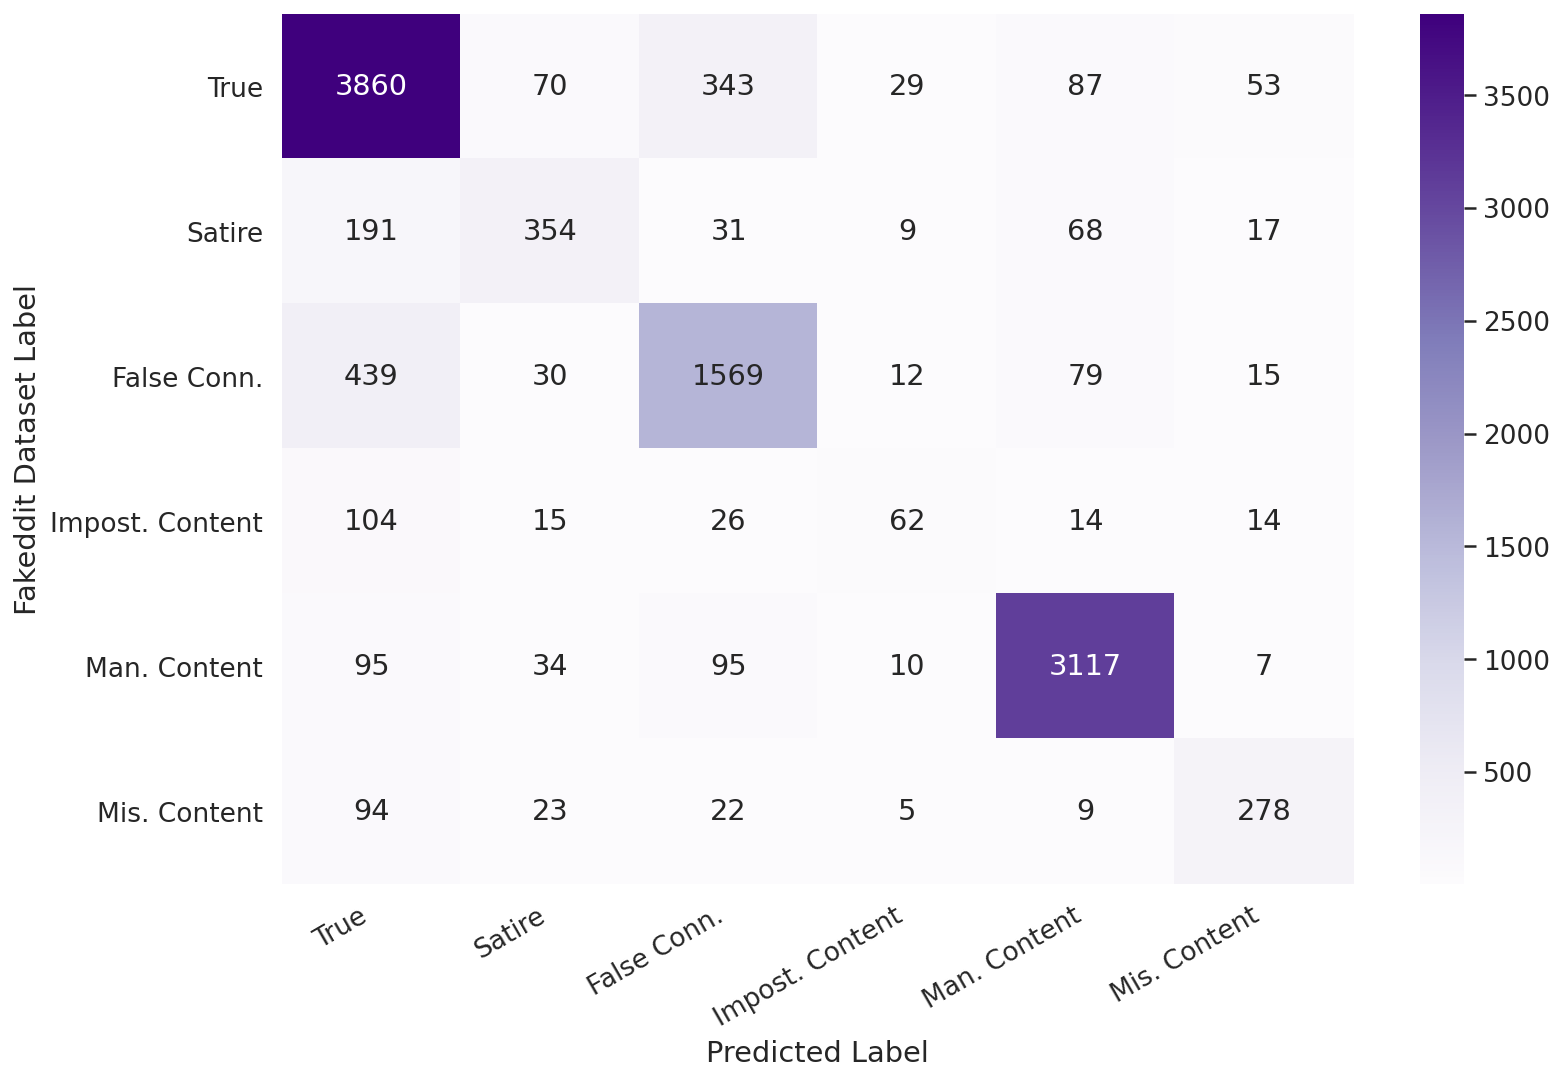

In [95]:
# Initialize confusion matrix plot name
cm_plot_name = "titleimage_detector_testing_confusion_matrix_15epochs"

# Function to generate and plot confusion matrix for Title-Image DistilFND
def plot_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    # Set x- and y-axis labels
    plt.ylabel("Fakeddit Dataset Label")
    plt.xlabel("Predicted Label")
    # Tighten layout of confusion matrix
    plt.tight_layout
    # Save confusion matrix in jpg format
    plt.savefig(f"/home/ubuntu/FakeNewsDetector/results/titleimage_research/{cm_plot_name}.jpg", bbox_inches="tight")

# Initialize confusion_matrix with y_test (ground truth labels) and predicted labels
cm = confusion_matrix(y_test.cpu(), y_preds.cpu())
# Plot and show resulting confusion matrix for Title-Image DistilFND
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
plot_confusion_matrix(df_cm)

`Cohen Kappa` score quantifies the inter-rater reliability of two raters rating an identical dataset. A large alignment of *1* or *100%* indicates that two raters separately classify each sample identically. In this context here, the `Cohen Kappa` score gives an indication of how much the predicted labels by the model are in alignment with the ground truth labels labeled by two researchers for the `Fakeddit` benchmark dataset. Hence, the Title DistilFND has an inter-rater alignment with the `Fakeddit` dataset of roughly *74,33%*.

In [96]:
# Calculating and printing Cohen Kappa Score
print(cohen_kappa_score(y_preds.cpu(), y_test.cpu()))

0.7432996703820605


Calulating the `receiver operating characteristic (ROC)` and `area under the curve (AUC)` scores for the Title DistilFND model. This gives an indication of the model's capability to separate between given classes by leveraging the `One-vs-One-Algorithm (OVO)`, which convrts the multi-class problem into a binary classification problem by calculating every pairwise combination of classes within the *6* defined classes. A value of *1* or *100%* indicates that the model has perfect separation capability and correctly classifies all samples, the goal then is to converge the `ROC-AUC` score towards *1* or *100%*. For comparison of different model variants of DistilFND, the `One-vs-One ROC-AUC score weighted by prevalence` is leveraged due to the highly imabalanced `Fakeddit` dataset. This minimizes the proportionally large effect on the evaluation criteria by an underrepresented class with only comparably view samples. Th weighted metrics are also used in above classification report in order to normalize the evaluation metrics across classes.

In [97]:
# Importing needed modules to calculate ROC-AUC scores
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [98]:
# Calculating ROC-AUC-Score with One-vs-One and One-vsRest algorithms, regular and weighted by prevalence
macro_roc_auc_ovo = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovo", average="macro")
# weighted_roc_auc_ovo is used for comparison of model variants of DistilFND
weighted_roc_auc_ovo = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovr", average="weighted")

print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.870805 (macro),
0.904594 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.908590 (macro),
0.935831 (weighted by prevalence)
